# Mini-project n° 2– Conditional VAEs

The objective of this mini-project is to define and train a Conditional VAE (CVAE).

In [2]:
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


On récupère les données du jeu de données FashionMNIST dont on va se servir pour entrainer notre CVAE

In [3]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

# Charger le jeu de données Fashion-MNIST
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# Création des échantillons test et train
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

La fonction ci-dessous va nous permettre de transformer les labels des données au format one-hot

In [4]:
#Récupération au format one-hot encoding des labels
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

On affiche ci-dessous neuf images aléatoires du jeu de données et de leur label correspondant

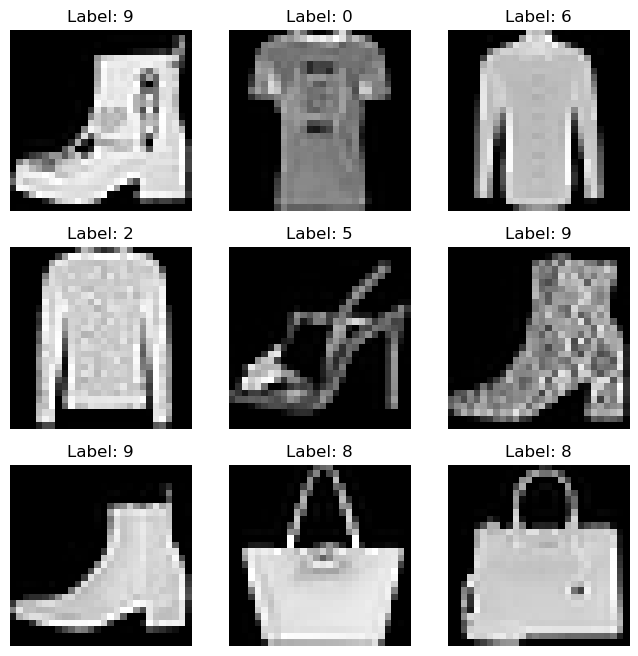

In [5]:
def plot_images(img_dataset):

    #Grille 3*3 pour permettre l'affichage de 9 images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
  
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  
        img, label = img_dataset[random_idx]  #récupération de l'image et de son label associé
        figure.add_subplot(rows, cols, i)  
        plt.title(f'Label: {label}') 
        plt.axis("off")  
        plt.imshow(img.squeeze(), cmap="gray") 
    
    plt.show()  

plot_images(train_dataset)

# Définition du modele : 

On met en place ici un modèle VAE Conditionnel. C'est un modèle où l'encodage latent dépend des images d'entrée mais également des labels associés à chaque image. L'objectif de ce modèle est donc de générer des images en fonction d'une étiquette de données spécifique.

La différence entre le VAE Conditionnel (CVAE) et le VAE est que l'on donne en entrée de l'encodeur et du décodeur du CVAE, un label pour lui donner l'information de ce qu'il a a produire. Ainsi, en ayant cette information, il peut se concentrer sur d'autres informations/aspects des données en entrée (la largeur de l'image, la densité de la coloration, etc).

Les images servent de modèles sur lesquels le décodeur peut se baser lors sa prédiction et les labels permettent ainsi de guider la prédiction vers un certain type d'image. 

Par exemple pour un VAE, on met en entrée de l'encodeur une image. Le décodeur doit donc reconnaitre cette image et tenter de la reproduire. Pour un CVAE, en plus de l'image donnée à l'encodeur, on fournit aussi le label de cette image (la catégorie à laquelle elle appartient) comme information conditionnelle au décodeur. Cela permet au décodeur 
de savoir d'avance qu'il doit reconstruire une image du label précisé, ce qui lui laisse plus de capacité pour se concentrer sur d'autres caractéristiques de l'image.



#### Choix de l'architecture : 

Pour le choix de l'architecture du modèle, nous avons choisi d'utiliser des couches convolutionnelles. En effet, celles-ci sont les plus adéquates pour l'analyse 
d'image, elles ont une approche locale et analysent les images zone par zone pour avoir des résultats précis. 
Les couches de convolution analyse graduellement l'image. La première couche analyse les petits motifs de l'image et les suivantes analysent les motifs de 
plus en plus gros.
 

#### Choix des hyperparamètres : 

Dans les hyper-paramètres du modèle, on décide d'optimiser uniquement le poids de régularisation (facteur β) et la dimension latente. Les hyper-paramètres de la taille du batch et du learning rate n'ont pas une grande influence donc on les prend arbitrairement à eps = 10-3 et taille du batch=128. 

L'optimisation du facteur β permet de trouver un compromis optimal de résultat, garantissant à la fois une reconstruction fidèle des données et une structure latente bien organisée.

La dimension latente détermine la capacité du modèle à capturer les informations pertinentes des données dans un espace de plus faible dimension.

La taille du batch influence en grande partie sur la stabilité de l'optimisation et la rapidité des calculs mais son impact n'a pas une grande influence sur les performences du modèle final. 

Le taux d'apprentissage détermine la vitesse à laquelle le modèle converge vers un minimum local. Il est donc important de bien le choisir, un ordre de grandeur entre 10-3 et 10-4 est généralement efficace. Optimiser ce paramètres n'est donc pas nécessaire dans un premier temps.

Le nombre d'époques détermine combien de fois le modèle parcourt l'ensemble des données d'entraînement. Ce paramètre permet d'assurer une bonne convergence du modèle 
sans provoquer de surapprentissage. 


In [6]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten the output of the convolutional layers

        # Concatenate the labels (one-hot encoded) with the encoder output
        x = torch.cat((x, labels), dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=1)
        z = z.to(device)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.sample(mu, logvar)
        return self.decode(z, labels), mu, logvar

## Fonction de perte 

#### Choix de la fonction de perte : 

Voici la formule de la fonction de perte que nous avons décidé d'utiliser : 

\begin{align*}
\text{Loss} &= \text{BCE} + \beta \cdot \text{KLD} \\
\newline
\text{où } \quad \text{BCE} &= -\sum_{i} \left( x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i) \right) \\
\text{KLD} &= -\frac{1}{2} \sum_{j} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
\end{align*}


Elle est composée de deux termes : la cross entropy binaire et la divergence de Kullback-Leibler.

La première partie de la fonction de perte correspond à l'erreur de reconstruction, elle permet donc d'évaluer notre modèle. Pour obtenir un modèle qui reconstruit bien, il faut minimiser la cross entropy entre la distribution de probabilité prédite et la réelle.

La divergence de Kullback-Leibler est un facteur de régularisation. Il permet de mesurer la divergence entre deux distributions de probabilité et indique la proportion d'information perdue en utilisant une distribution pour représenter l'autre. Ce facteur permet de gérer la qualité de représentation des données dans l'espace latent qui a un impact direct sur la qualité de génération de nouveaux échantillons de données. Il implique aussi à l'espace latent d'être distribué normalement autour de 0.

Le facteur β est un coefficient de pondération pour ajuster l'importance de la régularisation (terme KLD) par rapport à la reconstruction (terme cross-entropy). Plus β est grand, plus l'espace latent est proche d'une gaussienne centrée réduite. 



In [7]:
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

## Mise en place du modèle

Entrainement du modèle CVAE avec des paramètres arbitraires

In [8]:
import torch
import torch.optim as optim

# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 10
beta = 0.5  # Regularization factor for the KL Divergence, put to 0.5 as default

# Initialize the CVAE model and the Adam optimizer
cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10)  # Notez l'ajout de num_classes
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
# Training loop
for epoch in range(1, epochs + 1):
    cvae.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the cumulative loss for the current epoch

    # Iterate through the batches of training data
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)  # Move the input data to the GPU (if available)

        # Convert labels to one-hot encoding
        one_hot_labels = one_hot(labels, class_size=10).to(device)  # Assurez-vous que cela soit sur le bon device

        # Zero the gradients for this batch
        optimizer.zero_grad()

        # Forward pass through the model (passer les étiquettes aussi)
        recon_batch, mu, logvar = cvae(data, one_hot_labels)

        # Compute the loss for this batch
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]

        # Backpropagate the loss and update model parameters
        loss.backward()
        optimizer.step()

        # Accumulate the batch loss
        running_loss += loss.item()

    # Compute and print the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')


Epoch 1, Training loss: 268.7211
Epoch 2, Training loss: 254.6473
Epoch 3, Training loss: 253.2595
Epoch 4, Training loss: 252.4935
Epoch 5, Training loss: 251.6954
Epoch 6, Training loss: 251.2691
Epoch 7, Training loss: 250.8690
Epoch 8, Training loss: 250.4457
Epoch 9, Training loss: 250.2475
Epoch 10, Training loss: 250.0004


Visualisation des résultats : comparaison entre la vraie image et sa reconstruction

## mode evalution ??

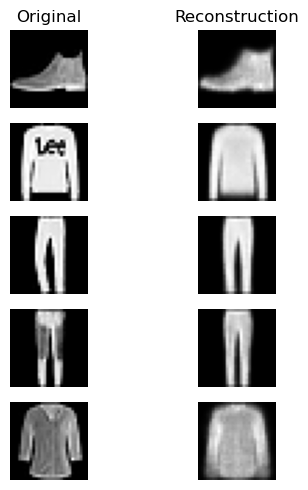

In [9]:
def image_comparison(original_images, reconstructions, n_images=5):

    fig, ax = plt.subplots(n_images, 2, figsize=(5, 5))

    for i in range(n_images):
        # Plot of original images
        ax[i, 0].imshow(original_images[i], cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_xlabel("0")
        ax[0, 0].set_title('Original')

        # Plot of reconstructed images
        ax[i, 1].imshow(reconstructions[i], cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_xlabel("1")
        ax[0, 1].set_title('Reconstruction')

    
    plt.tight_layout()
    plt.show()


# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae(random_images.to(device), one_hot_labels)  


random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()


image_comparison(random_images, recons)


Génération de 5 échantillons par classe.

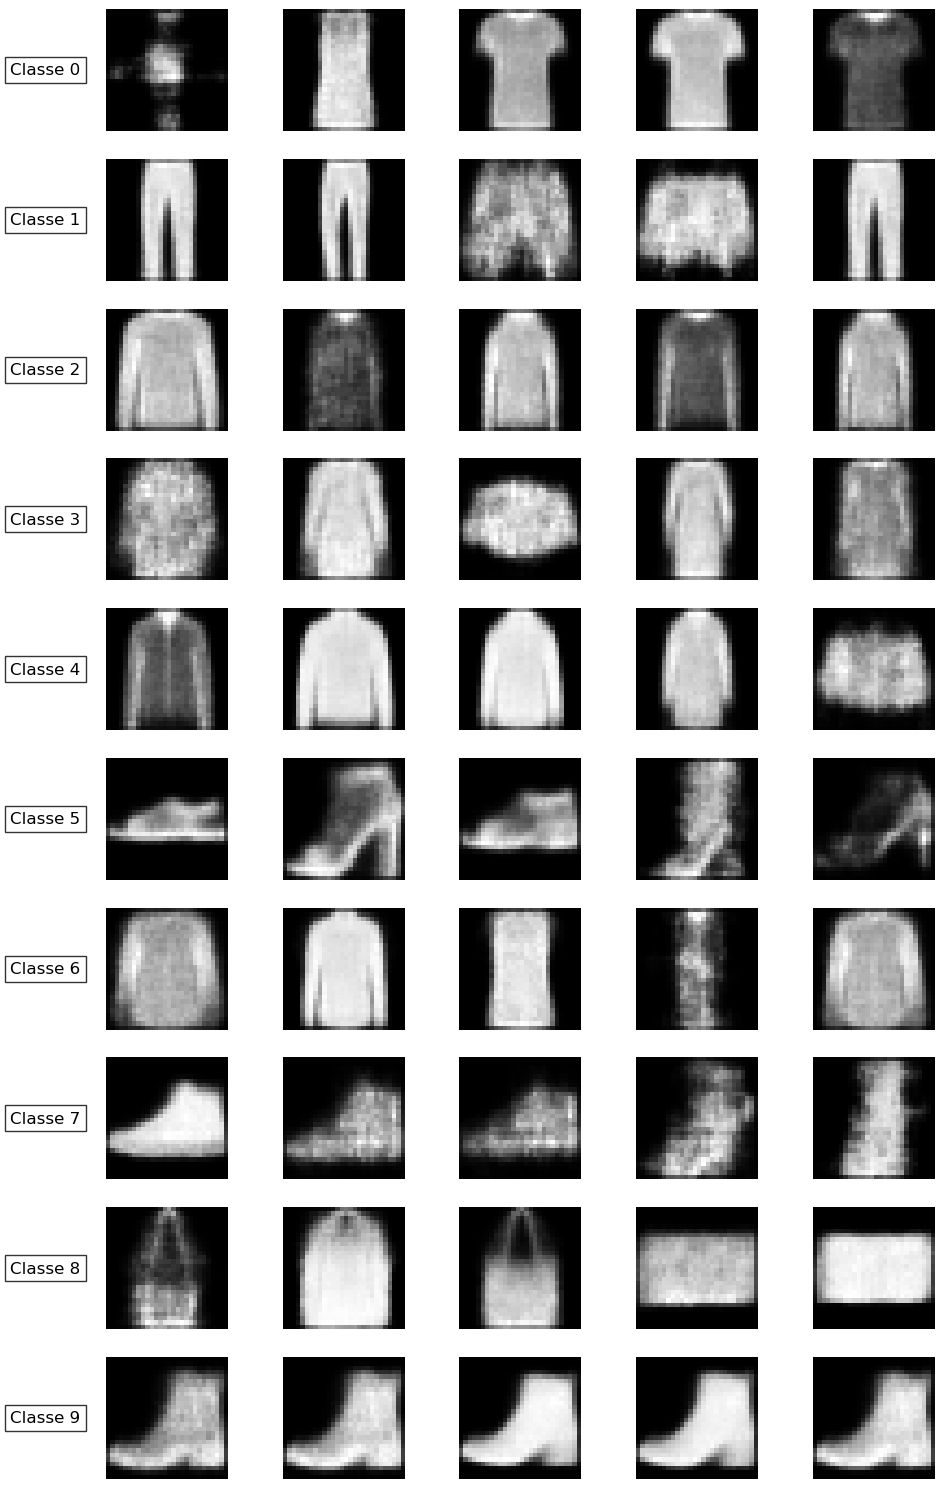

In [10]:
cvae.eval() #modèle en mode évaluation

num_classes = 10 
num_samples_per_class = 5 #nombre d'exemples par classe affichés

#Fonction pour générer et afficher des échantillons pour chaque classe
def generate_samples_per_class(model, num_classes, num_samples):
    samples = []
    for class_label in range(num_classes):
        class_samples = []
        for _ in range(num_samples):
         
            y = torch.tensor([class_label]).to(torch.long)
            y = torch.nn.functional.one_hot(y, num_classes).float()

            z = torch.randn(1, model.latent_dim) 
            
            #Passer z et y dans le décodeur
            with torch.no_grad():
                generated_image = model.decode(z, y)
                
            class_samples.append(generated_image.squeeze().cpu())
            
        samples.append(class_samples)
        
    return samples


#Générer les échantillons
samples = generate_samples_per_class(cvae, num_classes, num_samples_per_class)


fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, f"Classe {class_label}", 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

## Choix des hyperparamètres
Maintenant que nous avons des premiers résultats, nous nous intéressons aux choix des hyperparamètres.

### Visualisation de l'espace latent : influence du beta

On décide de visualiser la représentation de l'espace latent et la génération d'échantillons correspondants avec différentes valeurs de beta,donc différents poids de la KLD dans notre fonction de perte.
Cela nous permettrait de juger quel beta nous donne la meilleur génération, même si cela restera à nuancer avec la qualité de reconstruction.


Training VAE with beta = 1
Epoch 1: Average Loss: 272.3642, BCE: 267.6416, KLD: 4.7226
Epoch 2: Average Loss: 258.6388, BCE: 253.8819, KLD: 4.7569
Epoch 3: Average Loss: 256.9096, BCE: 252.1348, KLD: 4.7748
Epoch 4: Average Loss: 255.9815, BCE: 251.1987, KLD: 4.7827
Epoch 5: Average Loss: 255.3622, BCE: 250.6002, KLD: 4.7620
Epoch 6: Average Loss: 254.7632, BCE: 250.0071, KLD: 4.7561
Epoch 7: Average Loss: 254.2234, BCE: 249.4476, KLD: 4.7758
Epoch 8: Average Loss: 253.9099, BCE: 249.1464, KLD: 4.7634
Epoch 9: Average Loss: 253.6219, BCE: 248.8587, KLD: 4.7632
Epoch 10: Average Loss: 253.2754, BCE: 248.5190, KLD: 4.7563


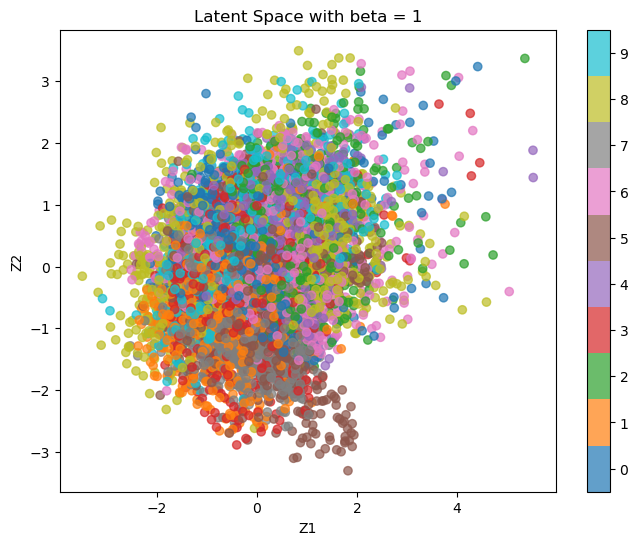

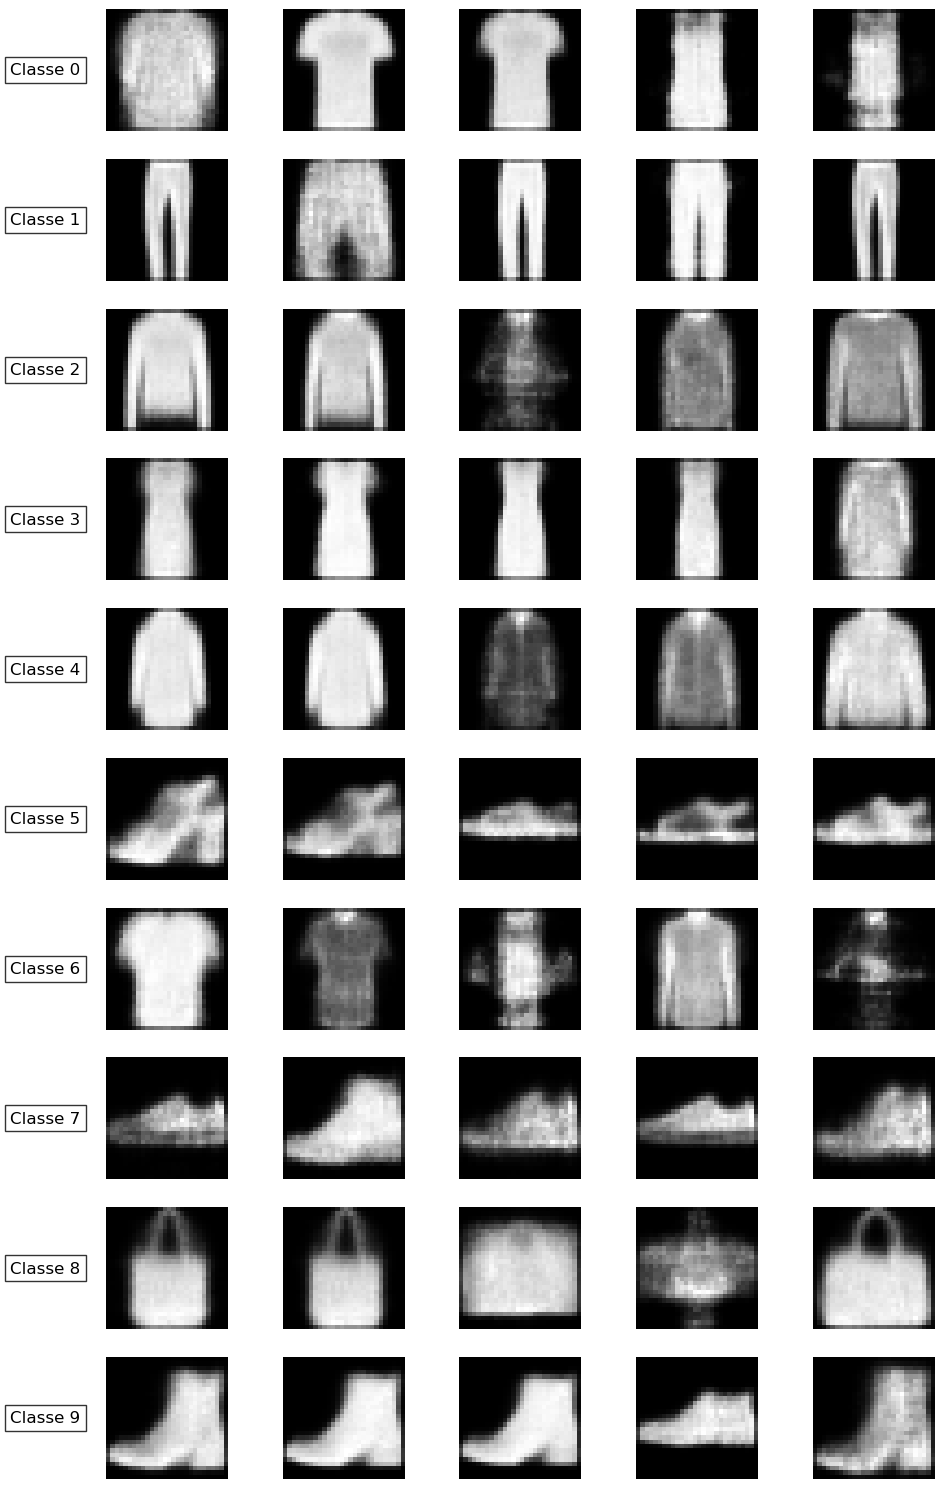


Training VAE with beta = 10
Epoch 1: Average Loss: 298.4057, BCE: 282.9654, KLD: 1.5440
Epoch 2: Average Loss: 283.1950, BCE: 266.3378, KLD: 1.6857
Epoch 3: Average Loss: 281.3921, BCE: 264.2648, KLD: 1.7127
Epoch 4: Average Loss: 280.5276, BCE: 263.1853, KLD: 1.7342
Epoch 5: Average Loss: 279.7219, BCE: 262.4231, KLD: 1.7299
Epoch 6: Average Loss: 279.0415, BCE: 261.7183, KLD: 1.7323
Epoch 7: Average Loss: 278.8592, BCE: 261.3432, KLD: 1.7516
Epoch 8: Average Loss: 278.5091, BCE: 260.8398, KLD: 1.7669
Epoch 9: Average Loss: 278.2401, BCE: 260.5914, KLD: 1.7649
Epoch 10: Average Loss: 278.0086, BCE: 260.3022, KLD: 1.7706


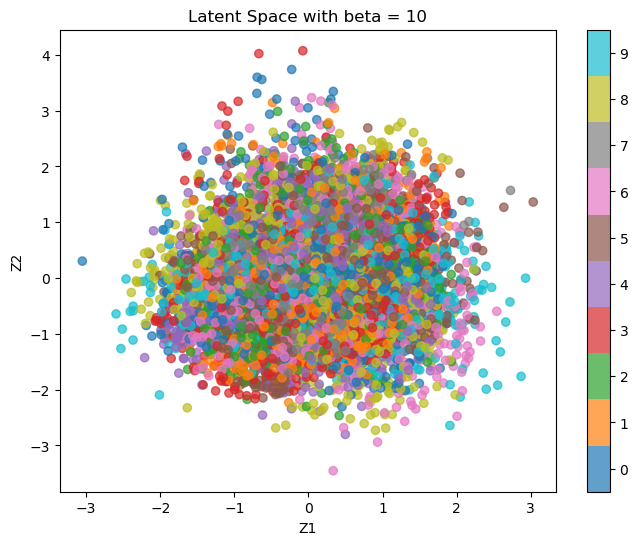

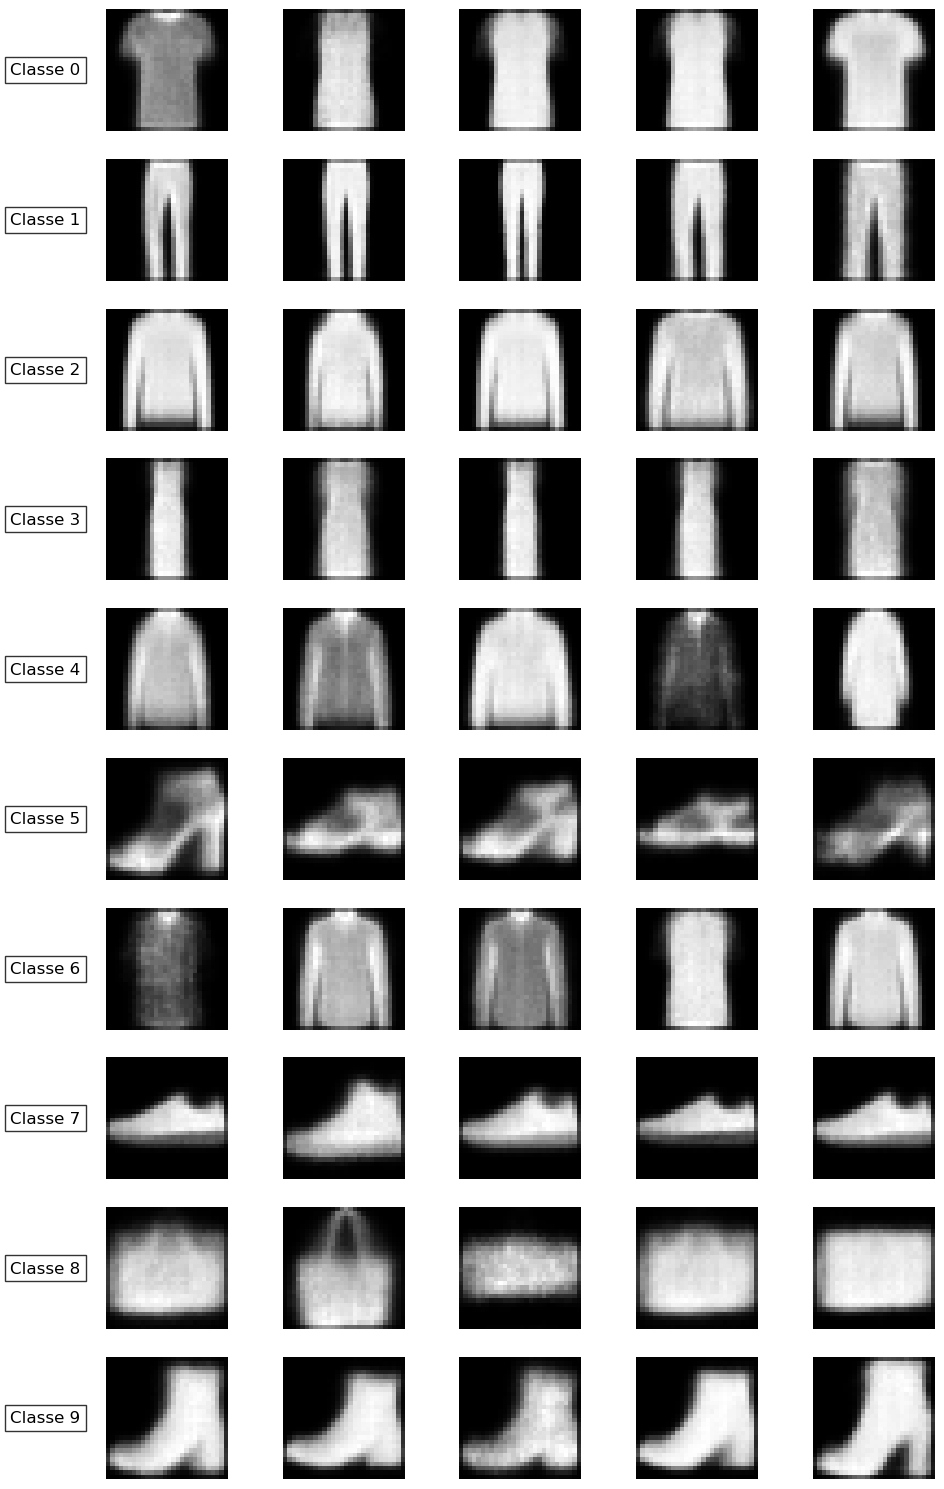


Training VAE with beta = 100
Epoch 1: Average Loss: 320.1994, BCE: 317.5136, KLD: 0.0269
Epoch 2: Average Loss: 308.0841, BCE: 307.9421, KLD: 0.0014
Epoch 3: Average Loss: 307.7952, BCE: 307.7024, KLD: 0.0009
Epoch 4: Average Loss: 307.6918, BCE: 307.5983, KLD: 0.0009
Epoch 5: Average Loss: 307.6095, BCE: 307.5331, KLD: 0.0008
Epoch 6: Average Loss: 307.6035, BCE: 307.5216, KLD: 0.0008
Epoch 7: Average Loss: 307.5561, BCE: 307.4730, KLD: 0.0008
Epoch 8: Average Loss: 307.5132, BCE: 307.4267, KLD: 0.0009
Epoch 9: Average Loss: 307.5069, BCE: 307.4248, KLD: 0.0008
Epoch 10: Average Loss: 307.4871, BCE: 307.4205, KLD: 0.0007


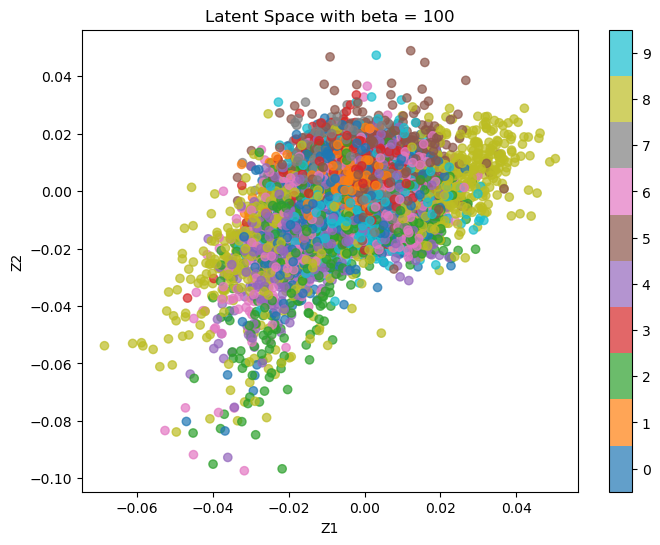

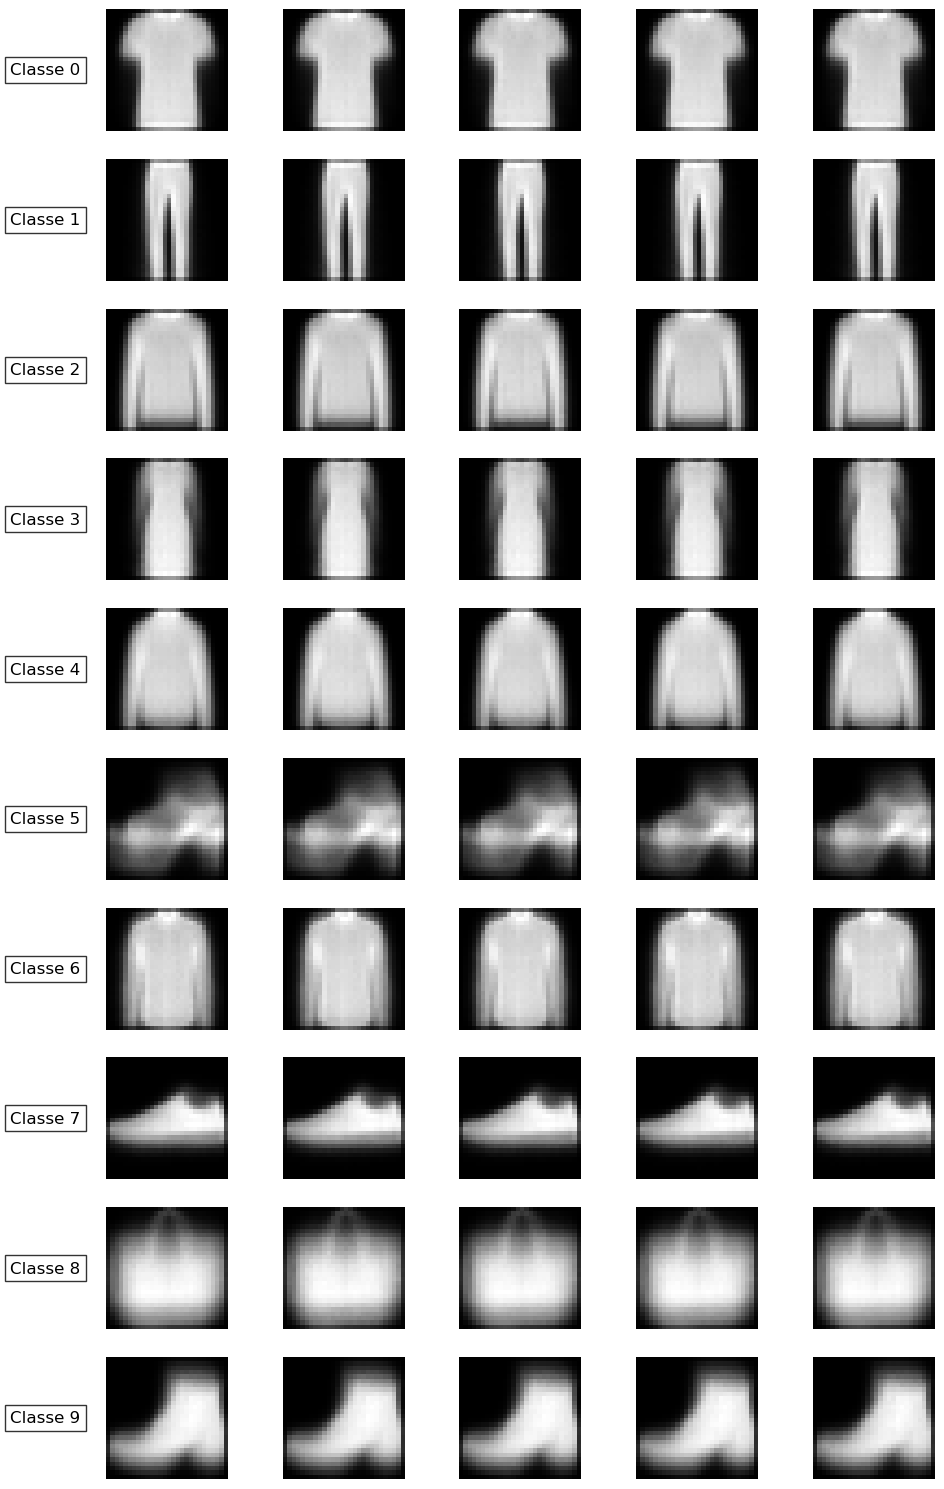

In [11]:
# Hyperparameters 
latent_dims = 2
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
beta = [1, 10, 100]  #optimisation du beta

def train_and_plot(beta):
    model = ConvCVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            one_hot_labels = one_hot(labels, class_size=10).to(device)

            optimizer.zero_grad()

            x_recon, mu, logvar = model(data, one_hot_labels)

            #calcul de la loss
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        #calcul de la loss par epoch
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')

   
    plot_latent_space(model, beta)
    return model


def plot_latent_space(model, beta):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device)

        mu, logvar = model.encode(data, one_hot_labels) 
        z = mu  
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with beta = {beta}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()


for b in beta:
    print(f'\nTraining VAE with beta = {b}')
    model = train_and_plot(b)

    model.eval() 

    num_classes = 10  
    num_samples_per_class = 5

    samples = generate_samples_per_class(model, num_classes, num_samples_per_class)

    
    fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))


    for class_label in range(num_classes):
        for sample_idx in range(num_samples_per_class):
        
            axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
            axs[class_label, sample_idx].axis("off")
        
        axs[class_label, 0].text(-0.5, 0.5, f"Classe {class_label}", 
                                rotation=0, size=12, ha="center", va="center",
                                bbox=dict(facecolor='white', alpha=0.8),
                                transform=axs[class_label, 0].transAxes)

    plt.tight_layout(h_pad=2)
    plt.show()


On remarque ici que plus beta est petit plus les différentes classes se distinguent dans la représentation de l'espace latent. Cependant, on ne peut pas mettre beta = 0 car si le facteur KLD de la fonction de perte ne serait pas du tout pris en compte et la qualité de reconstruction de l'image risque d'être faible.


In [12]:
from torch.utils.data import DataLoader 

test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
data, labels = next(iter(test_loader))
data.shape

torch.Size([10000, 1, 28, 28])

Pour avoir un résultat optimal, il faut non seulement minimiser la fonction de perte mais aussi il faut minimiser l'erreur de reconstruction des images. 

On choisit pour évaluer la qualité de reconstruction des images, la MSE. 

On affiche ci-dessous l'évolution de la MSE et de la fonction de perte en fonction de beta

In [14]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.optim as optim

def train_with_different_params(param_grid, batch_size=128) :
    history = {}
    mse_history = {}
    best_params = None
    best_loss = float('inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(10):  # Random search with 10 iterations
        params = {key: random.choice(value) for key, value in param_grid.items()}
        latent_dim = params['latent_dim']
        learning_rate = params['learning_rate']
        epochs = params['epochs']
        beta = params['beta']

        print(f"Training with params: {params}")

        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        epoch_losses = []
        epoch_mses = []
        
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            running_mse = 0.0
            
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                
                # Compute loss and MSE
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_mse += mse
            
            # Average loss and MSE over the dataset
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_mse = running_mse / len(train_loader.dataset)
            epoch_losses.append(epoch_loss)
            epoch_mses.append(epoch_mse)
            
            print(f'Epoch {epoch}, Beta {beta}, Latent_Dim {latent_dim}, Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}')
        
        history[beta] = epoch_losses
        mse_history[beta] = epoch_mses

    # Plotting loss curves for each beta
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    for beta, losses in history.items():
        plt.plot(losses, label=f'Beta: {beta}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss for Different Beta Values')

    plt.subplot(1, 2, 2)
    for beta, mses in mse_history.items():
        plt.plot(mses, label=f'Beta: {beta}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Mean Squared Error for Different Beta Values')

    plt.tight_layout()
    plt.show()
    
    return history, mse_history

In [15]:
# Hyperparameter grid for the search
param_grid = {
    #'batch_size': 128, fixer lors des split d'echantillons
    'latent_dim': [2, 4, 10, 20],  # Latent dimensions
    'epochs': [10],  # Number of epochs
    'beta': [1, 5, 10, 15],
    'learning_rate' : [1e-3]
}

train_with_different_params(param_grid)

Training with params: {'latent_dim': 2, 'epochs': 10, 'beta': 10, 'learning_rate': 0.001}
Epoch 1, Beta 10, Latent_Dim 2, Loss: 296.2028, MSE: 0.0003
Epoch 2, Beta 10, Latent_Dim 2, Loss: 282.9858, MSE: 0.0003
Epoch 3, Beta 10, Latent_Dim 2, Loss: 281.4348, MSE: 0.0003
Epoch 4, Beta 10, Latent_Dim 2, Loss: 280.3440, MSE: 0.0003
Epoch 5, Beta 10, Latent_Dim 2, Loss: 279.7366, MSE: 0.0002
Epoch 6, Beta 10, Latent_Dim 2, Loss: 279.1184, MSE: 0.0002
Epoch 7, Beta 10, Latent_Dim 2, Loss: 278.6313, MSE: 0.0002
Epoch 8, Beta 10, Latent_Dim 2, Loss: 278.3599, MSE: 0.0002
Epoch 9, Beta 10, Latent_Dim 2, Loss: 278.2886, MSE: 0.0002
Epoch 10, Beta 10, Latent_Dim 2, Loss: 277.9910, MSE: 0.0002
Training with params: {'latent_dim': 4, 'epochs': 10, 'beta': 1, 'learning_rate': 0.001}
Epoch 1, Beta 1, Latent_Dim 4, Loss: 267.4862, MSE: 0.0002
Epoch 2, Beta 1, Latent_Dim 4, Loss: 248.4067, MSE: 0.0002
Epoch 3, Beta 1, Latent_Dim 4, Loss: 246.1205, MSE: 0.0002


KeyboardInterrupt: 

D'après les résultats obtenus, la MSE et la fonction de perte sont toutes deux minimisées le plus avec un beta 

### Optimisation des paramètres par l'entrainement de modèles avec des combinaisons d'hyperparamètres différentes

In [ ]:
def train_with_different_params(param_grid, batch_size = 128 ):
    best_params = None
    best_loss = float('inf')
    best_mse = float('inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(10):  # Random search with 10 iterations
        params = {key: random.choice(value) for key, value in param_grid.items()}
        latent_dim = params['latent_dim']
        learning_rate = params['learning_rate']
        epochs = params['epochs']
        beta = params['beta']

        print(f"\nTraining with params: {params}")
        
        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            running_mse = 0.0
            
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                
                # Compute loss and MSE
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_mse += mse
            
            # Average loss and MSE over the dataset
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_mse = running_mse / len(train_loader.dataset)
            
            # Print epoch results
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}")
        

In [ ]:
param_grid = {
    'latent_dim': [2, 4, 10],  
    'epochs': [10],
    'beta': [1, 5, 10],
    'learning_rate' : [1e-3]
}

train_with_different_params(param_grid)

In [28]:
import pandas as pd
import itertools
import random

def train_with_different_params(param_grid, batch_size=128):
    # Générer toutes les combinaisons uniques d'hyperparamètres
    param_combinations = list(itertools.product(
        param_grid['latent_dim'],
        param_grid['learning_rate'],
        param_grid['epochs'],
        param_grid['beta']
    ))
    print(param_combinations)

    # Liste pour stocker les résultats
    results = []

    # Itérer sur chaque combinaison unique
    for latent_dim, learning_rate, epochs, beta in param_combinations:
        params = {
            "latent_dim": latent_dim,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "beta": beta
        }
        print(f"\nTraining with params: {params}")
        
        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            running_mse = 0.0
            
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                
                # Compute loss and MSE
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_mse += mse
            
            # Average loss and MSE over the dataset
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_mse = running_mse / len(train_loader.dataset)
            
            # Print epoch results
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}")
        
        # Store the results for this hyperparameter combination
        results.append({
            "latent_dim": latent_dim,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "beta": beta,
            "final_loss": epoch_loss,
            "final_mse": epoch_mse
        })

    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results)
    print("\nSummary of hyperparameter tuning:")
    print(results_df)
    
    # Optionally save results to a CSV file
    results_df.to_csv("hyperparameter_tuning_results.csv", index=False)
    
    return results_df


In [29]:
param_grid = {
    'latent_dim': [10, 20],  #2 : résultat pour la loss pas très bons
    'epochs': [10],
    'beta': [1, 5],
    'learning_rate' : [1e-3]
}

train_with_different_params(param_grid)

[(10, 0.001, 10, 1), (10, 0.001, 10, 5), (20, 0.001, 10, 1), (20, 0.001, 10, 5)]

Training with params: {'latent_dim': 10, 'learning_rate': 0.001, 'epochs': 10, 'beta': 1}
Epoch 1/10, Loss: 269.9371, MSE: 0.0002
Epoch 2/10, Loss: 244.5240, MSE: 0.0001
Epoch 3/10, Loss: 241.7595, MSE: 0.0001
Epoch 4/10, Loss: 240.3547, MSE: 0.0001
Epoch 5/10, Loss: 239.1315, MSE: 0.0001
Epoch 6/10, Loss: 238.3688, MSE: 0.0001
Epoch 7/10, Loss: 237.6909, MSE: 0.0001
Epoch 8/10, Loss: 237.2588, MSE: 0.0001
Epoch 9/10, Loss: 236.8258, MSE: 0.0001
Epoch 10/10, Loss: 236.3248, MSE: 0.0001

Training with params: {'latent_dim': 10, 'learning_rate': 0.001, 'epochs': 10, 'beta': 5}
Epoch 1/10, Loss: 291.3335, MSE: 0.0003
Epoch 2/10, Loss: 271.0850, MSE: 0.0002
Epoch 3/10, Loss: 268.4442, MSE: 0.0002
Epoch 4/10, Loss: 266.8075, MSE: 0.0002
Epoch 5/10, Loss: 265.8525, MSE: 0.0002
Epoch 6/10, Loss: 265.1435, MSE: 0.0002
Epoch 7/10, Loss: 264.4481, MSE: 0.0002
Epoch 8/10, Loss: 264.2019, MSE: 0.0002
Epoch 9/10, Loss

,latent_dim,learning_rate,epochs,beta,final_loss,final_mse
0,10,0.001,10,1,236.324797,0.000116
1,10,0.001,10,5,263.536541,0.000190
2,20,0.001,10,1,236.578052,0.000112
3,20,0.001,10,5,264.032623,0.000192


In [19]:
print(param_combinations)

NameError: name 'param_combinations' is not defined

### Optimisation des hyperparamètres avec la library Optuna

In [ ]:
import torch
import torch.optim as optim
import optuna

def objective(trial):
 
    latent_dim = trial.suggest_categorical('latent_dim', [2, 4, 10, 20])
    beta = trial.suggest_categorical('beta', [1, 5, 10, 15])

    
    cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
    
    running_loss = 0.0
    running_mse = 0.0
    
    for epoch in range(10): 
        cvae.train()
        for data, labels in train_loader:
            data = data.to(device)
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, one_hot_labels)
            
            loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
            mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_mse += mse

  
    avg_loss = running_loss / len(train_loader.dataset)
    avg_mse = running_mse / len(train_loader.dataset)
    return avg_mse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Meilleurs paramètres
print("\nBest trial:")
print(study.best_trial.params)


### Entrainement du modèle avec les hyperparamètres optimisés

In [ ]:
# Hyperparameters choisis par l'optimisation des hyperparametres précedentes
batch_size = 128
latent_dim = 20  #study.best_trial.params['latent_dim']
learning_rate = 1e-3
epochs = 20
beta = 1 #study.best_trial.params['beta']


cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10) 
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

for epoch in range(1, epochs + 1):
    cvae.train()  #entrainement du modèle
    
    #initialisation des métriques
    running_loss = 0.0  
    running_mse = 0.0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device) 

            
        one_hot_labels = one_hot(labels, class_size=10).to(device)  #conversion des labels

       
        optimizer.zero_grad()

        
        recon_batch, mu, logvar = cvae(data, one_hot_labels)

        
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        running_mse += mse

    #calcul de la loss et de la mse par epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mse = running_mse / len(train_loader.dataset)
    
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f},  Training mse: {epoch_mse:.4f}')


Epoch 1, Training loss: 266.1557,  Training mse: 0.0002
Epoch 2, Training loss: 245.3896,  Training mse: 0.0001
Epoch 3, Training loss: 242.5044,  Training mse: 0.0001
Epoch 4, Training loss: 240.6085,  Training mse: 0.0001
Epoch 5, Training loss: 239.4616,  Training mse: 0.0001
Epoch 6, Training loss: 238.6077,  Training mse: 0.0001
Epoch 7, Training loss: 237.9983,  Training mse: 0.0001
Epoch 8, Training loss: 237.4295,  Training mse: 0.0001
Epoch 9, Training loss: 236.9245,  Training mse: 0.0001
Epoch 10, Training loss: 236.5404,  Training mse: 0.0001
Epoch 11, Training loss: 236.2082,  Training mse: 0.0001
Epoch 12, Training loss: 236.0198,  Training mse: 0.0001
Epoch 13, Training loss: 235.6990,  Training mse: 0.0001
Epoch 14, Training loss: 235.4720,  Training mse: 0.0001
Epoch 15, Training loss: 235.2729,  Training mse: 0.0001
Epoch 16, Training loss: 235.0849,  Training mse: 0.0001
Epoch 17, Training loss: 234.9118,  Training mse: 0.0001
Epoch 18, Training loss: 234.7045,  Trai

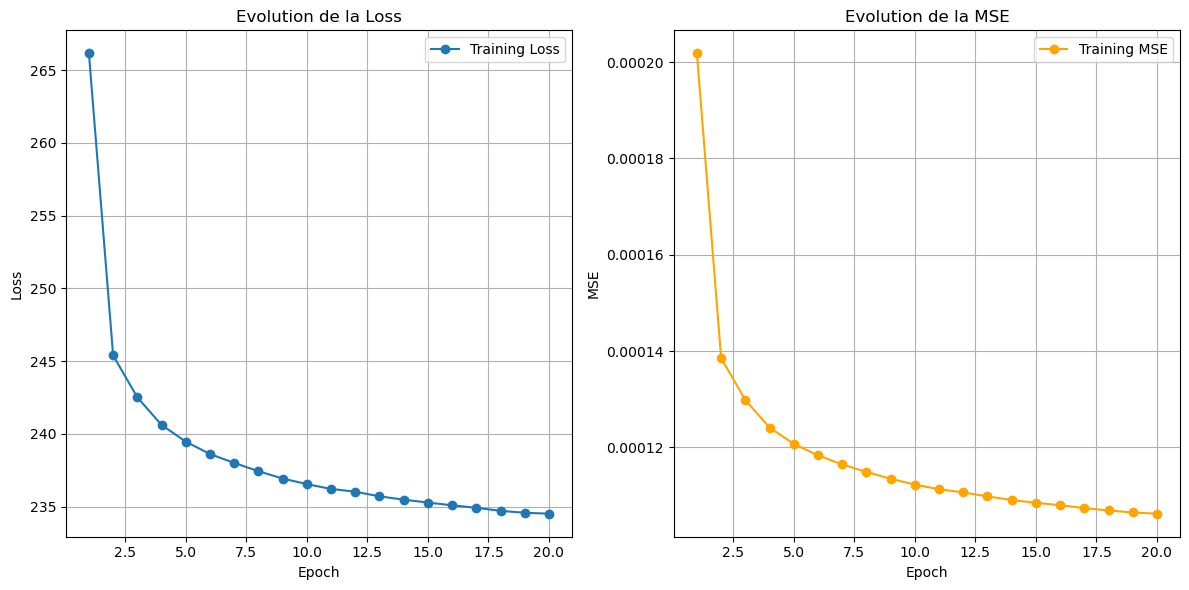

In [30]:
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
latent_dim = 20
learning_rate = 1e-3
epochs = 20
beta = 1

# Modèle et optimizer
cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10) 
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Listes pour stocker la loss et la MSE par epoch
loss_history = []
mse_history = []

for epoch in range(1, epochs + 1):
    cvae.train()  # Entraînement du modèle
    
    # Initialisation des métriques
    running_loss = 0.0  
    running_mse = 0.0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)  # Conversion des labels

        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, one_hot_labels)

        # Calcul des métriques
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse += mse

    # Calcul de la loss et de la MSE par epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mse = running_mse / len(train_loader.dataset)
    loss_history.append(epoch_loss)
    mse_history.append(epoch_mse)
    
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f},  Training mse: {epoch_mse:.4f}')

# Traçage des courbes
plt.figure(figsize=(12, 6))

# Courbe de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_history, marker='o', label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.grid()
plt.legend()

# Courbe de MSE
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), mse_history, marker='o', label="Training MSE", color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Evolution de la MSE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


## Visualisation des résultats

In [ ]:
# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae(random_images.to(device), one_hot_labels)  


random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()


image_comparison(random_images, recons)


Génération d'échantillons aléatoires

In [ ]:
#Générer les échantillons
num_samples_per_class = 3
num_classes = 10

samples = generate_samples_per_class(cvae, num_classes, num_samples_per_class)


fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, f"Classe {class_label}", 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

## 6. Interpolation between Images
The objective of this section is to visualize the difference between the space of latent representations and the (original) pixel space. In order to do so, we will perform *image interpolation*, i.e., we will take two random images $x_2$ and $x_2$ from the test set, and interpolate between them: for a given number of interpolation steps $n$, we have:
- In pixel space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by taking, for each pixel, the linear interpolation
$$\frac{n-t}{n}x_1 + \frac{t}{n}x_2.$$
- In the latent space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by first computing the linear interpolation $z_t$ between the encodings $z_1$ of $x_1$ and $z_2$ of $x_2$, and then decoding $z_t$.

In [ ]:
# TODO: Implement the interpolate_pixel_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

def interpolate_pixel_space(x1, x2, num_steps=10):
    # Ensure the images are on the same device and have the correct shape
    x1= x1[0].view(1, 1, 28, 28).to(device)
    x2 = x2[0].view(1, 1, 28, 28).to(device)

    # Generate interpolation factors between 0 and 1
    t_values = torch.linspace(0, 1, num_steps).to(device).view(-1, 1, 1, 1)

    # Interpolate directly in pixel space
    interpolated_images = x1 * (1 - t_values) + x2 * t_values
    # Déplacer les tenseurs sur le même dispositif
    #tensor1 = tensor1.to(device)
    #tensor2 = tensor2.to(device)
    interpolated_images = interpolated_images.cpu().squeeze(1)  # Remove channel dimension if necessary

    # Plot the interpolated images
    fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        ax[i].imshow(interpolated_images[i].squeeze(0), cmap='gray')
        ax[i].axis('off')
    plt.show()

x1, x2 = test_dataset[8][0], test_dataset[8][0]
interpolate_pixel_space(x1, x2)

In [ ]:
def interpolate_latent_space(x1, x2, num_steps=10):
    cvae.eval()
    with torch.no_grad():
        # Conversion des labels en one-hot
        one_hot_labels1 = one_hot(x1[1], class_size=10).to(device)
        one_hot_labels2 = one_hot(x2[1], class_size=10).to(device)

        # Redimensionner les entrées pour qu'elles soient en 4D
        input1 = x1[0].unsqueeze(0).to(device)  # Ajoute une dimension : (1, 28, 28) -> (1, 1, 28, 28)
        input2 = x2[0].unsqueeze(0).to(device)

        # Encoder
        recon_batch1, mu1, logvar1 = cvae.encode(input1, one_hot_labels1)
        recon_batch2, mu2, logvar2 = cvae.encode(input2, one_hot_labels2)

        # Obtenir les vecteurs latents
        z1 = cvae.sample(mu1, logvar1)
        z2 = cvae.sample(mu2, logvar2)

        # Interpolation dans l'espace latent
        z = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)]).to(device)
        z = z.view(num_steps, -1)  # Assurez-vous que z est en 2D (batch_size, latent_dim)

        # Répliquer les labels pour correspondre au nombre de points interpolés
        labels_interpolated = one_hot_labels1.view(1, -1).repeat(num_steps, 1)

        # Décodage
        samples = cvae.decode(z, labels_interpolated)
        samples = samples.view(num_steps, 1, 28, 28).cpu()  # Reshape pour afficher correctement

        # Visualisation
        fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
        for i in range(num_steps):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()
        
x1, x2 = test_dataset[8], test_dataset[8]
interpolate_pixel_space(x1, x2)
print('Label: ' + str(x1[1]))

# 8. Références

Explication sur les termes de la fonction de perte : https://medium.com/@mrthinger/kl-divergence-vs-cross-entropy-exploring-the-differences-and-use-cases-3f3dee58c452